In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [3]:
from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [4]:
from eppi_text_classification import OptunaHyperparameterOptimisation
from eppi_text_classification.utils import delete_optuna_study

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "XGBClassifier",
    n_trials_per_job=10,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
)

delete_optuna_study("xgb_binary")
best_params = optimiser.optimise_hyperparameters(study_name="xgb_binary")

[I 2024-07-15 12:43:22,293] A new study created in RDB with name: xgb_binary
[I 2024-07-15 12:44:22,224] Trial 6 finished with value: 0.8960131653807911 and parameters: {'reg_lambda': 0.37158075593980056, 'reg_alpha': 1.1772190147452475, 'learning_rate': 1.0717444297328553, 'max_depth': 1}. Best is trial 6 with value: 0.8960131653807911.
[I 2024-07-15 12:44:22,953] Trial 11 finished with value: 0.7917313740051671 and parameters: {'reg_lambda': 0.06809795466168185, 'reg_alpha': 0.0012777208726771426, 'learning_rate': 61.66465222059428, 'max_depth': 3}. Best is trial 6 with value: 0.8960131653807911.
[I 2024-07-15 12:44:23,109] Trial 10 finished with value: 0.918908338015421 and parameters: {'reg_lambda': 0.21632625782199602, 'reg_alpha': 0.0034877452427129617, 'learning_rate': 0.08451091452076046, 'max_depth': 1}. Best is trial 10 with value: 0.918908338015421.
[I 2024-07-15 12:44:24,150] Trial 0 finished with value: 0.7856585289914281 and parameters: {'reg_lambda': 0.09928553177783879,

In [5]:
# FIT THE MODEL

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# model = XGBClassifier(**best_params)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    colsample_bytree=1,
    n_jobs=-1,
    scale_pos_weight=42,
    reg_lambda=0.017636592766577953,
    reg_alpha=0.03834292094431529,
    learning_rate=0.4507787503025981,
    n_estimators=557,
    gamma=6.384905359051449e-10,
    max_depth=2,
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=7
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=6.384905359051449e-10, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4507787503025981, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=557, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
# CREATE ROC CURVE TO SELECT THRESHOLD

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

In [7]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)


threshold = get_raw_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [8]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

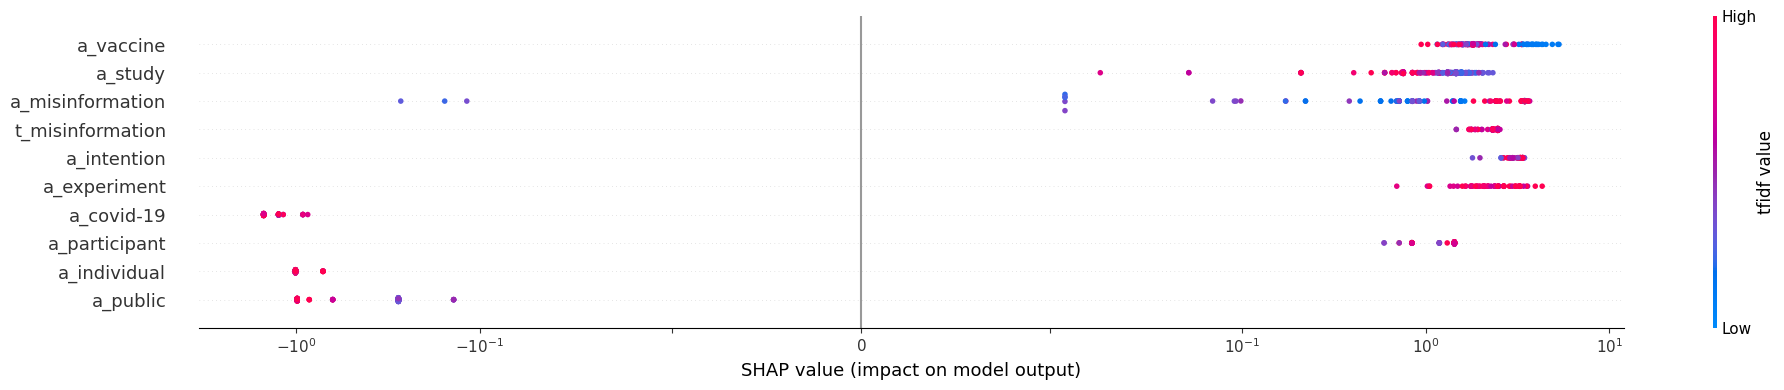

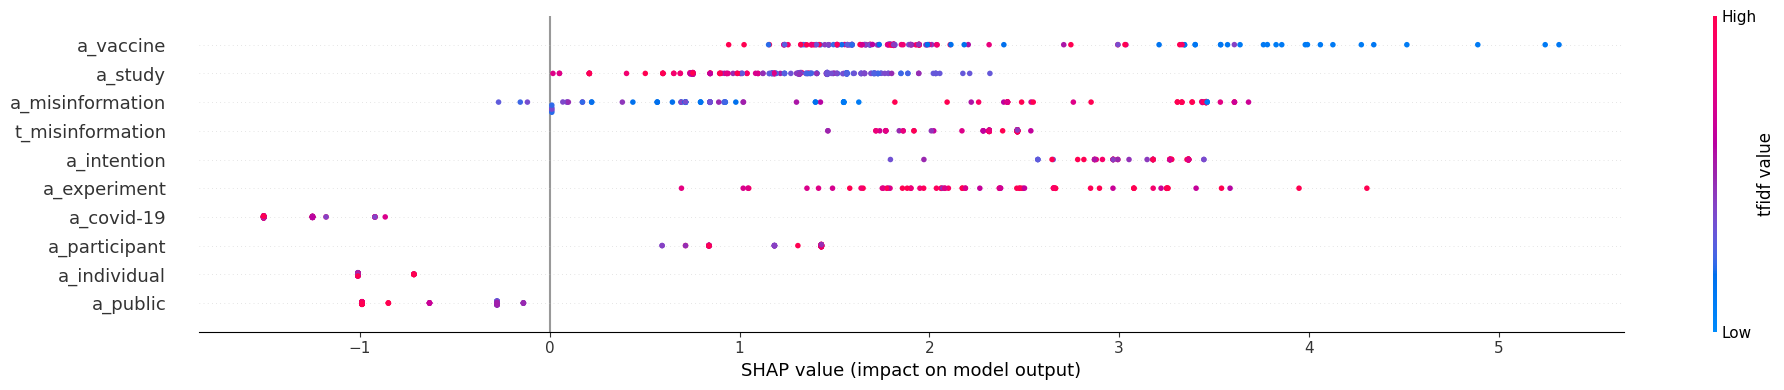

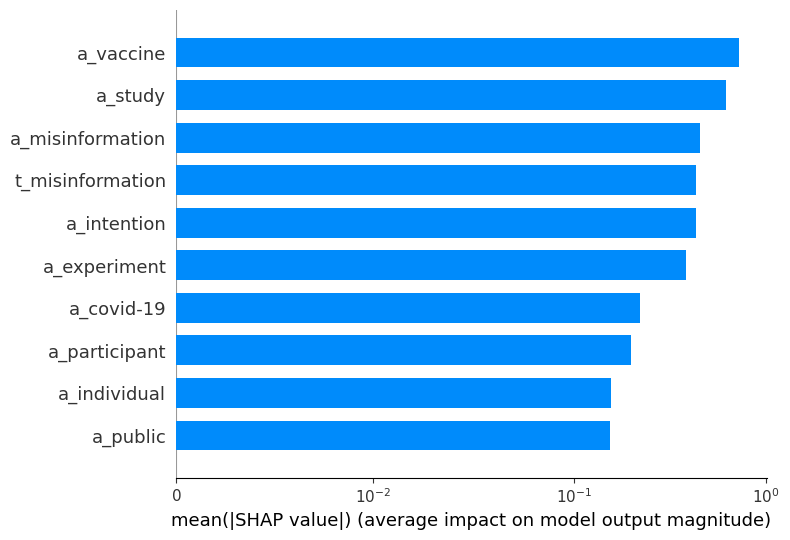

In [9]:
# EXLPAIN THE MODEL

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test, feature_names)

dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()
bar_plot.show()

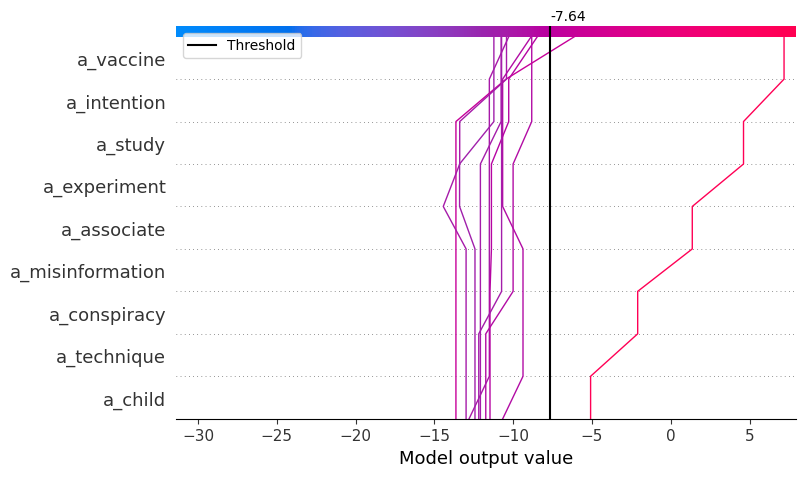

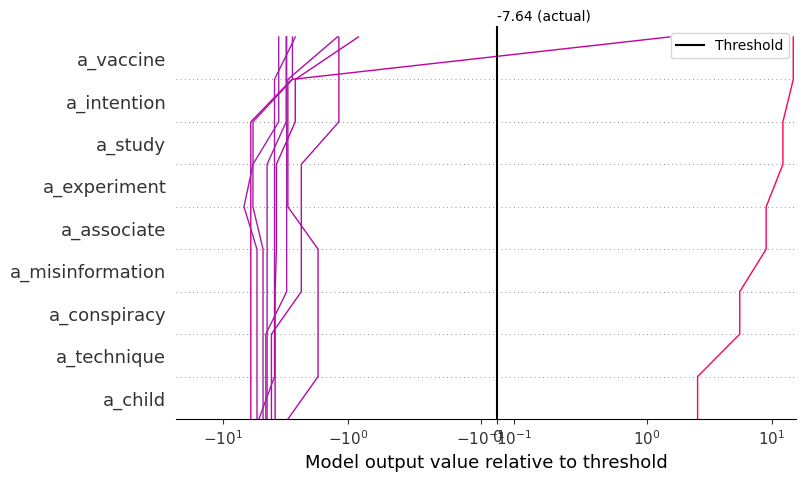

In [11]:
# MAKE THE DECISION PLOTS

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test[:10], feature_names)
decision_plot = shap_plotter.decision_plot(threshold=threshold, num_display=10)
decision_plot.show()
decision_plot = shap_plotter.decision_plot(
    threshold=threshold, num_display=10, log_scale=True
)
decision_plot.show()

Truth: 0
Prediction: [0]
Shap value: -8.824049095977522
Prediction score: [-8.82405]


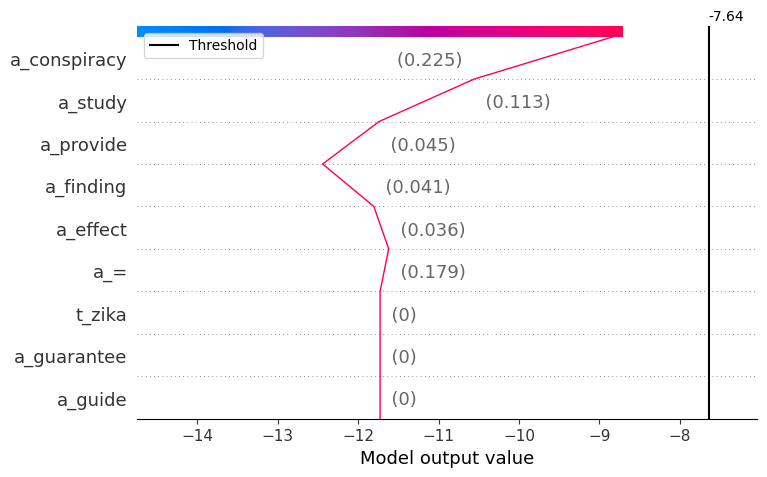

Truth: 1
Prediction: [1]
Shap value: 7.187546206749552
Prediction score: [7.18755]


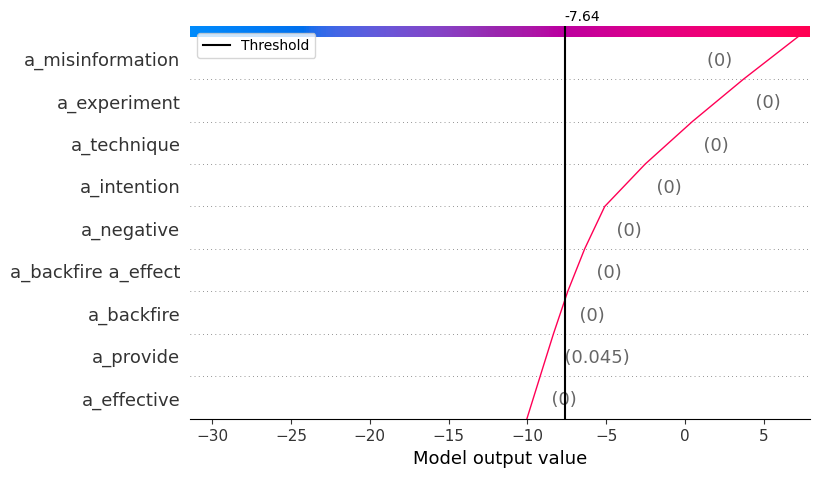

Truth: 0
Prediction: [0]
Shap value: -10.28047803871376
Prediction score: [-10.280476]


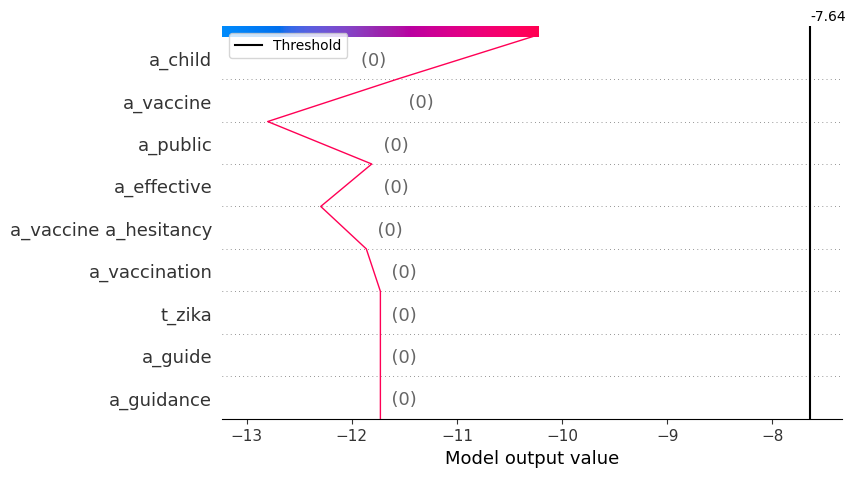

Truth: 0
Prediction: [0]
Shap value: -10.766501400042749
Prediction score: [-10.7665]


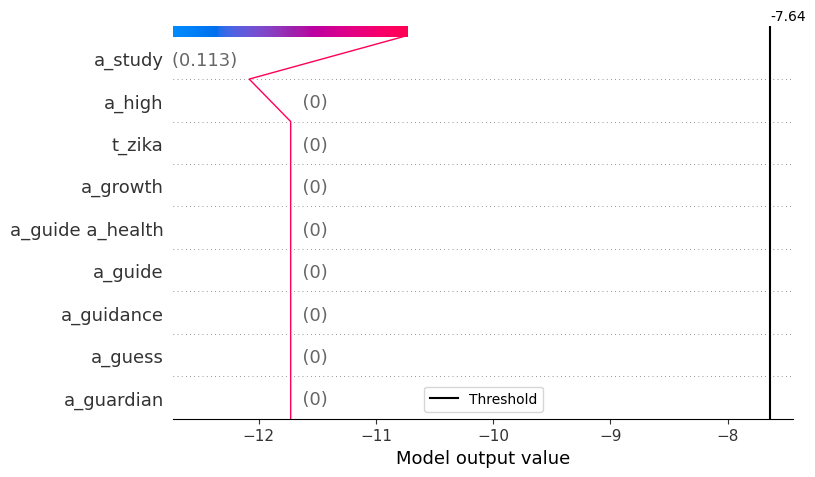

Truth: 0
Prediction: [1]
Shap value: -6.1125155034293
Prediction score: [-6.1125116]


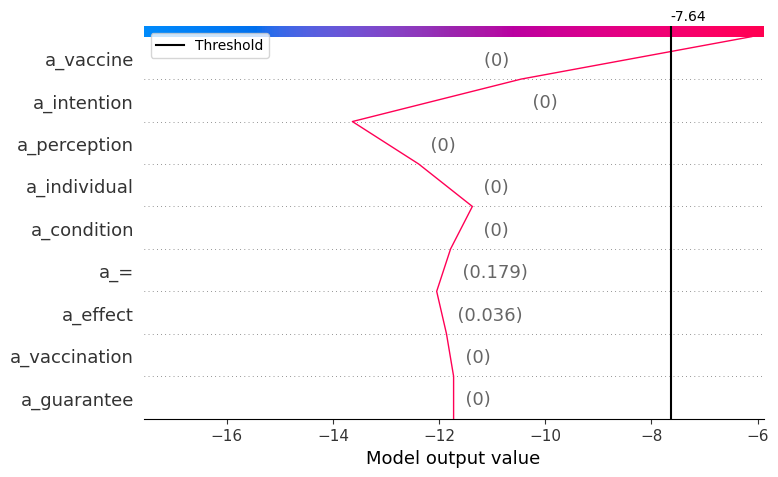

In [10]:
import numpy as np

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(
        f"Prediction: {raw_threshold_predict(model, np.expand_dims(X_test[i], axis=0), threshold)}"
    )
    print(
        f"Shap value: {np.sum(shap_plotter.shap_values[i]) + shap_plotter.expected_value}"
    )
    print(
        f"Prediction score: {predict_scores(model, np.expand_dims(X_test[i], axis=0))}"
    )
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()